# PBO on the chain walk environment

## Define parameters

In [1]:
%load_ext autoreload
%autoreload 2


import jax
import jax.numpy as jnp


# keys
seed = 5
key = jax.random.PRNGKey(seed)
env_key, key = jax.random.split(key)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

# Sample collection
n_states = 20
n_actions = 2
n_repetitions_list = jnp.array([2, 5, 20])
n_samples_list = n_states * n_actions * n_repetitions_list
sucess_probability = 0.9
gamma = 0.9

# Weights collection
n_weights = 100

# Trainings
max_bellman_iterations = 5

## PBOs
training_steps = 300
fitting_steps = 4
batch_size_samples = n_states
batch_size_weights = n_weights
learning_rates = [{"first": 0.01, "last": 0.00001, "duration": training_steps * fitting_steps * n_samples // batch_size_samples} for n_samples in n_samples_list]
add_infinity_non_linear = False


# Visualisation of errors and performances
max_bellman_iterations_validation = max_bellman_iterations + 20

## Define environment

In [2]:
import numpy as np
from pbo.environment.chain_walk import ChainWalkEnv


states = np.arange(n_states)
actions = np.arange(n_actions)
states_boxes = np.arange(n_states + 1) - 0.5
actions_boxes = np.arange(n_actions + 1) - 0.5

env = ChainWalkEnv(env_key, n_states, sucess_probability, gamma)

## Collect samples

### Samples on the mesh

In [3]:
import jax.numpy as jnp
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffers = [ReplayBuffer() for _ in range(len(n_repetitions_list))]

for state in states:
    for action in actions:
        # Need to repeat the samples to capture the randomness
        for n_current_repetition in range(n_repetitions_list[-1]):
            env.reset(jnp.array([state]))
            next_state, reward, absorbing, _ = env.step(jnp.array([action]))

            for idx_replay_buffer, n_repetitions in enumerate(n_repetitions_list):
                if n_current_repetition < n_repetitions:
                    replay_buffers[idx_replay_buffer].add(jnp.array([state]), jnp.array([action]), reward, next_state, absorbing)

_ = [replay_buffer.cast_to_jax_array() for replay_buffer in replay_buffers]

### Visualize samples

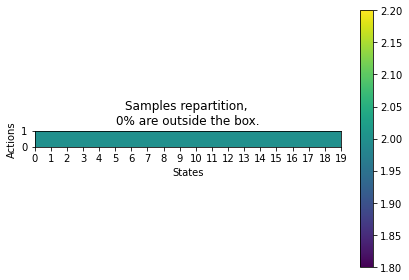

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh

idx_replay_buffer_to_view = 0

samples_count, n_outside_boxes, _ = count_samples(replay_buffers[idx_replay_buffer_to_view].states, replay_buffers[idx_replay_buffer_to_view].actions, states_boxes, actions_boxes, replay_buffers[idx_replay_buffer_to_view].rewards)
samples_visu_mesh = TwoDimesionsMesh(states, actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples_list[idx_replay_buffer_to_view])}% are outside the box."
)

## Optimal Q function

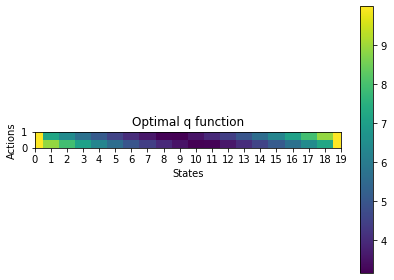

In [5]:
optimal_q = env.optimal_Q_mesh()
optimal_v = optimal_q.max(axis=1)

q_visu_mesh = TwoDimesionsMesh(states, actions, 0)

q_visu_mesh.set_values(optimal_q)
q_visu_mesh.show("Optimal q function")

## Optimal PBO

In [6]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import TableQ
from pbo.networks.learnable_pbo import TabularPBO


q = TableQ(
    1,
    n_states,
    1,
    n_actions,
    gamma,
    q_network_key,
    None,
    random_weights_key,
    None,
    zero_initializer=True,
)
validation_initial_weight = q.to_weights(q.params)


pbo_optimal = TabularPBO(q, max_bellman_iterations, False, pbo_network_key, learning_rates[0], n_actions)
pbo_optimal.params["TabularPBONet/linear"]["w"] = gamma * env.transition_proba.T
pbo_optimal.params["TabularPBONet/linear"]["b"] = env.R.T

training_losses_optimal = np.zeros(max_bellman_iterations_validation)
validation_losses_optimal = np.zeros(max_bellman_iterations_validation)
value_functions_optimal = np.zeros((max_bellman_iterations_validation, n_states))


batch_iterated_weights = validation_initial_weight.reshape((1, -1))
for bellman_iteration in range(max_bellman_iterations_validation):
    q_i = q.discretize(batch_iterated_weights, states, actions)[0]
    batch_iterated_weights = pbo_optimal(pbo_optimal.params, batch_iterated_weights)
    q_i_plus_1 = q.discretize(batch_iterated_weights, states, actions)[0]
    policy_q = q_i_plus_1.argmax(axis=1)

    training_losses_optimal[bellman_iteration] = jnp.abs(env.apply_bellman_operator(q_i) - q_i_plus_1).mean()
    validation_losses_optimal[bellman_iteration] = jnp.abs(optimal_q - q_i_plus_1).mean()
    value_functions_optimal[bellman_iteration] = env.value_function(policy_q)
    print(policy_q)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1

## Collect weights

In [7]:
from pbo.weights_collection.weights_buffer import WeightsBuffer


weights_buffer = WeightsBuffer()

# Add initial validation weights
weights_buffer.add(validation_initial_weight)

# Add randow weights
q_random = TableQ(
    1,
    n_states,
    1,
    n_actions,
    gamma,
    q_network_key,
    None,
    random_weights_key,
    learning_rate=None,
    zero_initializer=False,
)

while len(weights_buffer) < n_weights:
    weights = q_random.random_init_weights()
    weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## Train non linear PBO

In [8]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import TabularPBO


training_losses_non_linear = np.zeros((len(n_repetitions_list), max_bellman_iterations_validation))
validation_losses_non_linear = np.zeros((len(n_repetitions_list), max_bellman_iterations_validation))
value_functions_non_linear = np.zeros((len(n_repetitions_list), max_bellman_iterations_validation, n_states))
pbos_params = []

for idx_repetition in range(len(n_repetitions_list)):
    data_loader_samples = SampleDataLoader(replay_buffers[idx_repetition], batch_size_samples, shuffle_key)
    data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
    pbo_non_linear = TabularPBO(q_random, max_bellman_iterations, add_infinity_non_linear, pbo_network_key, learning_rates[idx_repetition], n_actions)
    importance_iteration = jnp.ones(max_bellman_iterations + 1)
    importance_iteration = importance_iteration.at[-1].set(0)

    for _ in tqdm(range(training_steps)):
        params_target = pbo_non_linear.params

        for _ in range(fitting_steps):
            data_loader_weights.shuffle()
            for batch_weights in data_loader_weights:
                data_loader_samples.shuffle()
                for batch_samples in data_loader_samples:
                    pbo_non_linear.params, pbo_non_linear.optimizer_state, _ = pbo_non_linear.learn_on_batch(
                        pbo_non_linear.params, params_target, pbo_non_linear.optimizer_state, batch_weights, batch_samples, importance_iteration
                    )

    pbos_params.append(pbo_non_linear.params)
    print("Samples with ", n_repetitions_list[idx_repetition], " repetions.")
    
    batch_iterated_weights = validation_initial_weight.reshape((1, -1))
    for bellman_iteration in range(max_bellman_iterations_validation):
        q_i = q.discretize(batch_iterated_weights, states, actions)[0]
        batch_iterated_weights = pbo_non_linear(pbo_non_linear.params, batch_iterated_weights)
        q_i_plus_1 = q.discretize(batch_iterated_weights, states, actions)[0]
        policy_q = q_i_plus_1.argmax(axis=1)

        training_losses_non_linear[idx_repetition, bellman_iteration] = jnp.abs(env.apply_bellman_operator(q_i) - q_i_plus_1).mean()
        validation_losses_non_linear[idx_repetition, bellman_iteration] = jnp.abs(optimal_q - q_i_plus_1).mean()
        value_functions_non_linear[idx_repetition, bellman_iteration] = env.value_function(policy_q)
        print(policy_q)

  0%|          | 0/300 [00:00<?, ?it/s]

Samples with  2  repetions.
[1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0]
[1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0]
[1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 1 1 0]
[1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0]
[1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0

  0%|          | 0/300 [00:00<?, ?it/s]

Samples with  5  repetions.
[1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1 1 0 1]
[1 0 1 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1]
[1 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1]
[1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1]
[1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1]
[0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0

  0%|          | 0/300 [00:00<?, ?it/s]

Samples with  20  repetions.
[1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[1 0 

## Visualize errors in Q functions

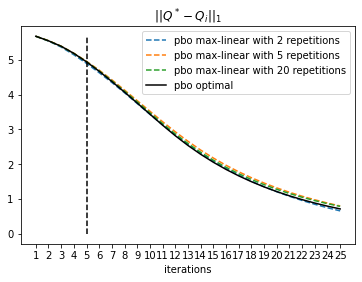

In [9]:
import matplotlib.pyplot as plt 

iterations = range(1, max_bellman_iterations_validation + 1)

for idx_repetition in range(len(n_repetitions_list)):
    plt.plot(iterations, validation_losses_non_linear[idx_repetition], label=f"pbo max-linear with {n_repetitions_list[idx_repetition]} repetitions", linestyle="--")
plt.plot(iterations, validation_losses_optimal, label="pbo optimal", color="black")
plt.vlines(max_bellman_iterations, 0, np.max(validation_losses_non_linear), color="black", linestyle="--")

plt.xticks(iterations)
plt.xlabel("iterations")

plt.title(r"$|| Q^* - Q_i ||_1$")
_ = plt.legend()

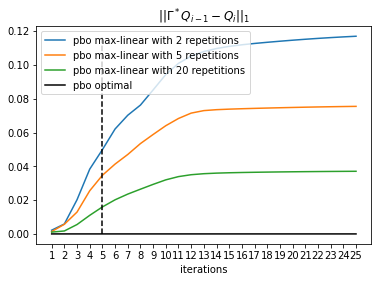

In [10]:
for idx_repetition in range(len(n_repetitions_list)):
    plt.plot(iterations, training_losses_non_linear[idx_repetition], label=f"pbo max-linear with {n_repetitions_list[idx_repetition]} repetitions")
plt.plot(iterations, training_losses_optimal, label="pbo optimal", color="black")
plt.vlines(max_bellman_iterations, 0, np.max(training_losses_non_linear), color="black", linestyle="--")

plt.xticks(iterations)
plt.xlabel("iterations")

plt.title(r"$|| \Gamma^*Q_{i-1} - Q_i ||_1$")
_ = plt.legend()

## Distance between empirical and theoretical probabilities

In [11]:
for idx_repetition in range(len(n_repetitions_list)):
    empirical_transition_proba = np.zeros((n_states, n_states * n_actions))
    empirical_reward = np.zeros(n_states * n_actions)

    for idx_sample in range(len(replay_buffers[idx_repetition].states)):
        state = replay_buffers[idx_repetition].states[idx_sample, 0]
        action = replay_buffers[idx_repetition].actions[idx_sample, 0]
        reward = replay_buffers[idx_repetition].rewards[idx_sample, 0]
        next_state = replay_buffers[idx_repetition].next_states[idx_sample, 0]

        empirical_transition_proba[next_state, state * n_actions + action] += 1 
        empirical_reward[state * n_actions + action] += reward

    empirical_transition_proba /= n_repetitions_list[idx_repetition]
    empirical_reward /= n_repetitions_list[idx_repetition]

    print(f"-- For {n_repetitions_list[idx_repetition]} repetitions --")
    print(f"Probability transition:")
    print("Empirical vs Theoretical - ", np.linalg.norm(empirical_transition_proba - env.transition_proba.T))
    print("Empirical vs Learnt - ", np.linalg.norm(empirical_transition_proba - pbos_params[idx_repetition]["TabularPBONet/linear"]["w"] / gamma))
    print("Theoretical vs Learnt - ", np.linalg.norm(env.transition_proba.T - pbos_params[idx_repetition]["TabularPBONet/linear"]["w"] / gamma))
    print("\nReward:")
    print("Empirical vs Theoretical - ", np.linalg.norm(empirical_reward - env.R.T))
    print("Empirical vs Learnt - ", np.linalg.norm(empirical_reward - pbos_params[idx_repetition]["TabularPBONet/linear"]["b"]))
    print("Theoretical vs Learnt - ", np.linalg.norm(env.R.T - pbos_params[idx_repetition]["TabularPBONet/linear"]["b"]))
    print()


-- For 2 repetitions --
Probability transition:
Empirical vs Theoretical -  2.0297782
Empirical vs Learnt -  0.09072141
Theoretical vs Learnt -  2.0328057

Reward:
Empirical vs Theoretical -  0.0
Empirical vs Learnt -  0.033229835
Theoretical vs Learnt -  0.033229835

-- For 5 repetitions --
Probability transition:
Empirical vs Theoretical -  1.2328827
Empirical vs Learnt -  0.07581758
Theoretical vs Learnt -  1.2321594

Reward:
Empirical vs Theoretical -  0.0
Empirical vs Learnt -  0.015414132
Theoretical vs Learnt -  0.015414132

-- For 20 repetitions --
Probability transition:
Empirical vs Theoretical -  0.6284902
Empirical vs Learnt -  0.051024463
Theoretical vs Learnt -  0.6278354

Reward:
Empirical vs Theoretical -  0.0
Empirical vs Learnt -  0.009433087
Theoretical vs Learnt -  0.009433087



## Visualize errors in preformances

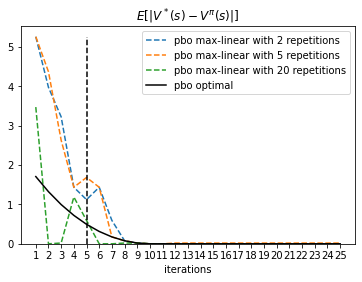

In [12]:
for idx_repetition in range(len(n_repetitions_list)):
    plt.plot(iterations, np.abs(value_functions_non_linear[idx_repetition] - optimal_v).mean(axis=1), label=f"pbo max-linear with {n_repetitions_list[idx_repetition]} repetitions", linestyle="--")
plt.plot(iterations, np.abs(value_functions_optimal - optimal_v).mean(axis=1), label="pbo optimal", color="black")
plt.vlines(max_bellman_iterations, 0, np.abs(value_functions_non_linear[0] - optimal_v).mean(axis=1).max(), color="black", linestyle="--")

plt.xticks(iterations)
plt.ylim(0)
plt.xlabel("iterations")

plt.title(r"$E[| V^*(s) - V^{\pi}(s) |]$")
_ = plt.legend()